In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install transformers datasets accelerate

# Init

In [1]:
import torch
print(torch.__version__)
print('CUDA', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.1.2
CUDA False
cpu


In [4]:
from huggingface_hub import login
login()

# Toy models

In [5]:
gen_func = lambda x, y: x * y

# create a dataset
import numpy as np

def create_dataset(size=50):
    x = np.random.randint(0, 2, size=(size, 2))
    y = np.array([gen_func(*i) for i in x])
    return x, y

x, y = create_dataset()
print(x.shape, y.shape)

(50, 2) (50,)


In [195]:
# create a NN which is actually a linear regression model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2, bias=True)
        self.fc2 = nn.Linear(2, 1, bias=True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x

net = Net()
print(net)

for name, param in net.named_parameters():
    print(name, param.data)

criterion = nn.MSELoss()
output = net(torch.Tensor(x))
loss = criterion(output, torch.Tensor(y).unsqueeze(1))
print(loss)

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)
fc1.weight tensor([[-0.4290,  0.0741],
        [ 0.0591, -0.4155]])
fc1.bias tensor([-0.6921, -0.5397])
fc2.weight tensor([[-0.6809,  0.5924]])
fc2.bias tensor([0.4357])
tensor(0.3360, grad_fn=<MseLossBackward0>)


In [194]:
# init fc1 weights
net.fc1.weight.data = torch.tensor([[.1, .1]])
for name, param in net.named_parameters():
    print(name, param.data)

# compute loss
criterion = nn.MSELoss()
output = net(torch.Tensor(x))
loss = criterion(output, torch.Tensor(y).unsqueeze(1))
print(loss)

fc1.weight tensor([[0.1000, 0.1000]])
fc1.bias tensor([-0.6207, -0.2708])
fc2.weight tensor([[-0.6328, -0.4621]])
fc2.bias tensor([-0.6190])


RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [50, 1].  Tensor sizes: [2]

In [196]:
# train the model
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
#optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(3000):
    optimizer.zero_grad()
    output = net(torch.Tensor(x))
    loss = criterion(output, torch.Tensor(y).unsqueeze(1))
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} loss: {loss.item()}")

Epoch 0 loss: 0.3359938859939575
Epoch 1000 loss: 0.0040109301917254925
Epoch 2000 loss: 7.330396329052746e-06


In [197]:
# run on example
print([gen_func(*i) for i in [[0, 0], [0, 1], [1, 0], [1, 1]]])
print(net(torch.Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])).squeeze().tolist())

[0, 0, 0, 1]
[0.0, 0.00011417269706726074, 0.0001138150691986084, 0.9998772740364075]


In [198]:
# show weights of all layers
for name, param in net.named_parameters():
    print(name, param.data)

fc1.weight tensor([[-0.6996, -0.6789],
        [ 0.3487,  0.3663]])
fc1.bias tensor([-0.2600, -0.9916])
fc2.weight tensor([[-0.9012,  1.0591]])
fc2.bias tensor([-0.1837])


In [219]:
# show calculated weights
input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
print('input', input)
first_layer_weights = net.fc1.weight.data.numpy()
print('1st weight', first_layer_weights)
# calculate weights on input
#first_layer_weights = np.dot(input, first_layer_weights.T)
x = net.fc1(torch.Tensor(input))
print('1st result', first_layer_weights)
# calculate weights on second layer
second_layer_weights = net.fc2.weight.data.numpy()
print('2nd weight', second_layer_weights)
second_layer_weights = np.dot(first_layer_weights, second_layer_weights.T)
print('2nd result', second_layer_weights)
print('output', F.relu(torch.Tensor(second_layer_weights)).tolist())

input [[0 0]
 [0 1]
 [1 0]
 [1 1]]
1st weight [[-0.6995617  -0.6788511 ]
 [ 0.3487244   0.36634612]]
1st result [[ 0.          0.        ]
 [-0.67885113  0.36634612]
 [-0.69956172  0.3487244 ]
 [-1.37841284  0.71507052]]
2nd weight [[-0.901158   1.0591389]]
2nd result [[0.        ]
 [0.99976353]
 [0.99976319]
 [1.99952672]]
output [[0.0], [0.999763548374176], [0.9997631907463074], [1.9995267391204834]]


In [224]:
# show calculated weights
input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
print('input', input)
first_layer_weights = net.fc1.weight.data.numpy()
print('1st weight', first_layer_weights)
# calculate weights on input
#first_layer_weights = np.dot(input, first_layer_weights.T)
x = net.fc1(torch.Tensor(input))
print('1st result', x)
# calculate weights on second layer
second_layer_weights = net.fc2.weight.data.numpy()
print('2nd weight', second_layer_weights)
x = net.fc2(x)
print('2nd result', x)
print('output', F.relu(torch.Tensor(x)).tolist())

input [[0 0]
 [0 1]
 [1 0]
 [1 1]]
1st weight [[-0.6995617  -0.6788511 ]
 [ 0.3487244   0.36634612]]
1st result tensor([[-0.2600, -0.9916],
        [-0.9389, -0.6253],
        [-0.9596, -0.6429],
        [-1.6384, -0.2766]], grad_fn=<AddmmBackward0>)
2nd weight [[-0.901158   1.0591389]]
2nd result tensor([[-9.9965e-01],
        [ 1.1417e-04],
        [ 1.1382e-04],
        [ 9.9988e-01]], grad_fn=<AddmmBackward0>)
output [[0.0], [0.00011417269706726074], [0.0001138150691986084], [0.9998772740364075]]


# LLAMA 2

In [228]:
from transformers import AutoModelForCausalLM

# Model from Hugging Face hub
base_model = "NousResearch/Llama-2-7b-chat-hf"

llama_2_model = AutoModelForCausalLM.from_pretrained(base_model)

/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 583/583 [00:00<00:00, 78.9kB/s]
model.safetensors.index.json: 100%|██████████| 26.8k/26.8k [00:00<00:00, 5.70MB/s]
model-00001-of-00002.safetensors: 100%|██████████| 9.98G/9.98G [02:46<00:00, 59.7MB/s]
model-00002-of-00002.safetensors: 100%|██████████| 3.50G/3.50G [00:59<00:00, 59.1MB/s]
generation_config.json: 100%|██████████| 179/179 [00:00<00:00, 13.0kB/s]
/Users/shach

In [229]:
# print model architecture with number of parameters
print(llama_2_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [231]:
# test model with a simple prompt
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(base_model)

In [236]:
import transformers
import torch
pipeline = transformers.pipeline(
    "text-generation",
    model=llama_2_model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [246]:
sequences = pipeline(
    'Who are you?\n',
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=20,
)

In [248]:
for seq in sequences:
    print(f"{seq}")

{'generated_text': 'Who are you?\n\nAnswer:\n\nI am the one who holds the pen, who'}


In [253]:
'JFKSFOATLJFKATLSFO' > 'JFKATLSFOATLJFKSFO'

True

# Target reduction

### MNIST

In [3]:
# Download ImageNet from Hugging Face hub

from datasets import load_dataset

# dataset = load_dataset("cifar100")
dataset = load_dataset("mnist")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

### CIFAR

In [292]:
# load labels from cifar-100-labels.json
import json
with open('cifar-100-labels.json') as f:
    cifar_labels = json.load(f)

labels_list = list(set([x['fine_label'] for x in dataset['train']]))
labels_list.sort()

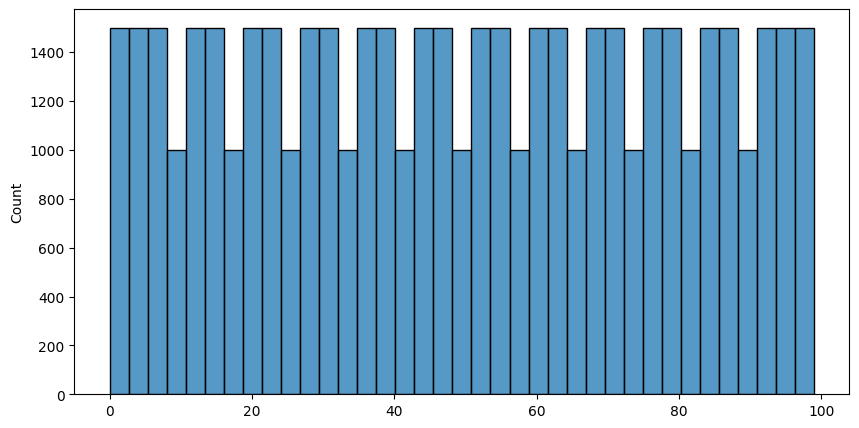

In [290]:
# show histogram of labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot([x['fine_label'] for x in dataset['train']])
plt.show()

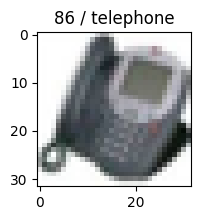

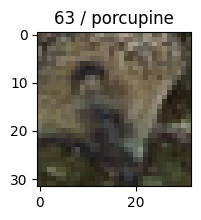

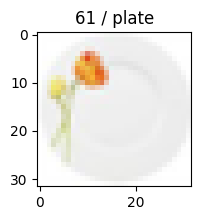

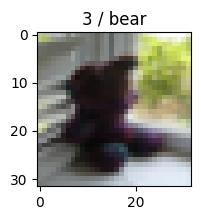

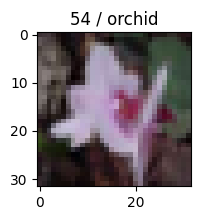

In [ ]:
# sample images from dataset
import random

def sample_images(dataset, n=5):
    for i in range(n):
        x = random.choice(dataset['train'])
        plt.figure(figsize=(2, 2))
        plt.imshow(x['img'])
        plt.title(str(x['fine_label']) + ' / ' + cifar_labels[x['fine_label']])
        plt.show()

sample_images(dataset)

In [ ]:
import numpy as np
import torch
import torchvision

def convert_dataset(dataset, labels_list):
    x = torch.stack([torch.Tensor(np.array(x['img'])) for x in dataset])
    # standardize images
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    y = torch.tensor([x['fine_label'] for x in dataset])
    return x, y

x, y = convert_dataset(dataset['train'], cifar_labels)
# print shapes
print(x.shape, y.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([50000])


In [ ]:
x_test, y_test = convert_dataset(dataset['test'], cifar_labels)
# print shapes
print(x_test.shape, y_test.shape)

torch.Size([10000, 32, 32, 3]) torch.Size([10000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '39 / keyboard')

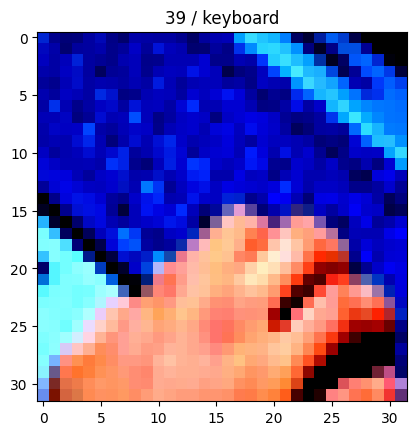

In [ ]:
img_idx = 10
sample_img = x[img_idx].numpy()
# print labels from y tensor (y is one-hot encoded)
label_idx = y[img_idx].tolist()

plt.imshow(sample_img)
plt.title(str(label_idx) + ' / ' + cifar_labels[label_idx])

In [ ]:
# train simple CNN model using PyTorch

import torch
import torch.nn as nn

class Net(nn.Module):

    def __init__(self, global_scale=1.0, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, int(6 * global_scale), 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(int(6 * global_scale), int(16 * global_scale), 5, padding=2)
        self.fc1 = nn.Linear(int(16 * 8 * 8 * global_scale), int(120 * global_scale))
        self.fc2 = nn.Linear(int(120 * global_scale), num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net(num_classes=len(cifar_labels))
print(net)

# print how many parameters are in the model overall
print(sum(p.numel() for p in net.parameters()))

example = torch.Tensor(x.permute(0, 3, 1, 2)[:1])
print(example.shape)
net(example)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)
137972
torch.Size([1, 1, 28, 28])


RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead

### MNIST

In [298]:
labels_list = list(set([x['label'] for x in dataset['train']]))
labels_list.sort()
labels_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

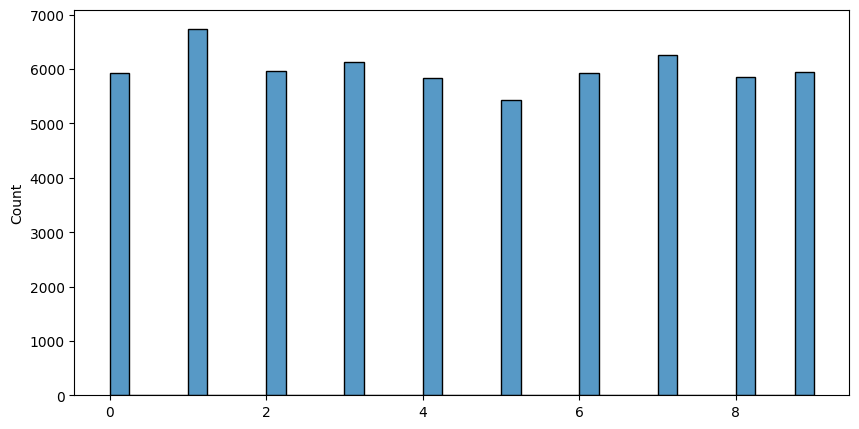

In [274]:
# show histogram of labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot([x['label'] for x in dataset['train']])
plt.show()

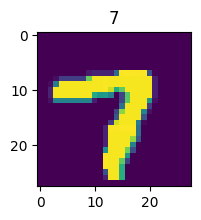

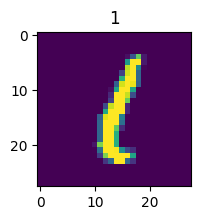

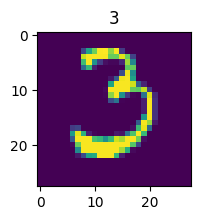

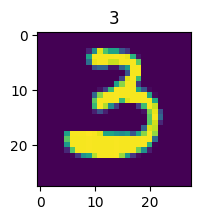

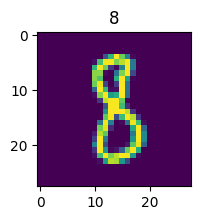

In [275]:
# sample images from dataset
import random

def sample_images(dataset, n=5):
    for i in range(n):
        x = random.choice(dataset['train'])
        plt.figure(figsize=(2, 2))
        plt.imshow(x['image'])
        plt.title(str(x['label']))
        plt.show()

sample_images(dataset)

In [328]:
import numpy as np
import torch

def convert_dataset(dataset):
    x = torch.stack([torch.Tensor(np.array(x['image'])) for x in dataset])
    # add channel dimension to the end of the vector
    x = x.unsqueeze(-1)
    # standardize images
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    y = torch.tensor([x['label'] for x in dataset])
    return x, y

x, y = convert_dataset(dataset['train'])
# print shapes
print(x.shape, y.shape)

torch.Size([60000, 28, 28, 1]) torch.Size([60000])


In [358]:
x_test, y_test = convert_dataset(dataset['test'])
# print shapes
print(x_test.shape, y_test.shape)

torch.Size([10000, 28, 28, 1]) torch.Size([10000])


In [364]:
# train simple CNN model using PyTorch

import torch
import torch.nn as nn

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization
    
net = Net()
print(net)

# print how many parameters are in the model overall
# print([p.numel() for p in net.parameters()])
print(sum(p.numel() for p in net.parameters()))

example = torch.Tensor(x.permute(0, 3, 1, 2)[:1])
print(example.shape)
test_output, last_layer = net(example)
test_output


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
28938
torch.Size([1, 1, 28, 28])


tensor([[-0.1227,  0.0112, -0.1500, -0.1445,  0.0027, -0.0990, -0.3956, -0.1386,
         -0.0443, -0.2099]], grad_fn=<AddmmBackward0>)

In [365]:
# train the model

import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10
subset_size = y.shape[0]
subset_size = 10000

x_subset = x[:subset_size].permute(0, 3, 1, 2)
y_subset = y[:subset_size]
print(x_subset.shape, y_subset.shape)

for epoch in range(num_epochs):
    running_loss = 0.0
    # take input from x and y tensors
    for i, data in enumerate(zip(x_subset, y_subset)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(inputs)   # batch x
        b_y = Variable(labels)   # batch y

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(b_x.unsqueeze(0))
        # if type is tuple then take the first element
        if type(outputs) == tuple:
            outputs = outputs[0]
        loss = criterion(outputs, b_y.unsqueeze(0))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # print every 2000 mini-batches
        sample_i = 20000
        if i % (sample_i) == (sample_i - 1):
            print(f"Epoch {epoch} loss: {running_loss / 200}")

    print(f"Epoch {epoch} loss: {running_loss / len(x)}")
    

torch.Size([10000, 1, 28, 28]) torch.Size([10000])
Epoch 0 loss: 0.034032449539515654
Epoch 1 loss: 0.014300764335449797
Epoch 2 loss: 0.010379805333194011
Epoch 3 loss: 0.008382915367403923
Epoch 4 loss: 0.008040177810449077
Epoch 5 loss: 0.008298217469796277
Epoch 6 loss: 0.007582225632815101
Epoch 7 loss: 0.00785976189475457
Epoch 8 loss: 0.006957016873932123
Epoch 9 loss: 0.005684739345922658


Epoch 0 loss: 0.09238324410438538
Epoch 1 loss: 0.09186878878593445
Epoch 2 loss: 0.0911579831457138
Epoch 3 loss: 0.08888038264036179
Epoch 4 loss: 0.08236994886327535
Epoch 5 loss: 0.07122399962589145
Epoch 6 loss: 0.05814928394056144
Epoch 7 loss: 0.0440202156470115
Epoch 8 loss: 0.03162076760299708
Epoch 9 loss: 0.022221988647022753
Epoch 10 loss: 0.01579706007343012
Epoch 11 loss: 0.0126834562904543
Epoch 12 loss: 0.01027612510225742
Epoch 13 loss: 0.008361674948036206
Epoch 14 loss: 0.007377226570392954
Epoch 15 loss: 0.007797221151621687
Epoch 16 loss: 0.0060949457158199155
Epoch 17 loss: 0.0058425939958498315
Epoch 18 loss: 0.0054484944161447
Epoch 19 loss: 0.004683076893747991

In [366]:
x_in = x_test.permute(0, 3, 1, 2)
y_test_pred = torch.argmax(net(x_in)[0], dim=1)
y_test_pred.shape

torch.Size([10000])

In [367]:
# show values count for y_test_pred
import pandas as pd
pd.Series(y_test_pred.numpy()).value_counts()

1    1146
2    1061
9    1048
7    1015
3    1003
0     999
4     955
6     944
8     941
5     888
Name: count, dtype: int64

In [368]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.96      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Composability split try 1

### Class Embeddings

In [ ]:
!pip install wheel setuptools pip --upgrade
!pip install fasttext

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
words_emb = fasttext.load_model('cc.en.300.bin')

In [ ]:
fasttext.util.reduce_model(words_emb, 10)
words_emb.get_dimension()

10

In [ ]:
def get_ft_vector(ftmodel, text):
    if len(text.split('_')) == 0:
        return ftmodel.get_word_vector(text)
    else:
        # replace _ with space
        text = text.replace('_', ' ')
        return ftmodel.get_sentence_vector(text)
    
get_ft_vector(words_emb, 'hello_man')

array([ 0.02354577, -0.09955808, -0.3461216 , -0.31151217, -0.5118708 ,
       -0.10864205, -0.01830762, -0.10666388,  0.4581535 ,  0.12405477],
      dtype=float32)

In [ ]:
def kMostSimilar(all_embeddings_corpus, embs_vectors, k=1):
    # find k nearest neighbors
    from sklearn.metrics.pairwise import cosine_similarity
    cos_sim = cosine_similarity(embs_vectors, all_embeddings_corpus)
    # sort by similarity
    top_k = np.argsort(-cos_sim, axis=1)[:, :k]
    return top_k

cifar_vectors = torch.Tensor([get_ft_vector(words_emb, l) for l in cifar_labels])

sample_words = ['man', 'apple', 'pinecone', 'nice man']
sample_inputs = torch.Tensor([get_ft_vector(words_emb, w) for w in sample_words])
print(cifar_vectors.shape, sample_inputs.shape)

kSimilars = kMostSimilar(cifar_vectors, sample_inputs, k=5)
print(kSimilars.shape)
for i, w in enumerate(sample_words):
    print(f'[{w}]', ' -> '.join([cifar_labels[knn] for knn in kSimilars[i]]))
    

torch.Size([100, 10]) torch.Size([4, 10])
(4, 5)
[man] man -> woman -> boy -> girl -> lion
[apple] apple -> bee -> squirrel -> turtle -> crab
[pinecone] crab -> sweet_pepper -> maple_tree -> pear -> lobster
[nice man] girl -> boy -> couch -> man -> lion


In [ ]:
import numpy as np
import torch
import torchvision

def convert_dataset_embs(dataset, labels_list):
    x = torch.stack([torch.Tensor(np.array(x['img'])) for x in dataset])
    # standardize images
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    y = torch.tensor([x['fine_label'] for x in dataset])
    y_embs = torch.stack([torch.Tensor(get_ft_vector(words_emb, labels_list[x['fine_label']])) for x in dataset])
    return x, y, y_embs

x, y, y_embs = convert_dataset_embs(dataset['train'], cifar_labels)
# print shapes
print(x.shape, y.shape, y_embs.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([50000]) torch.Size([50000, 10])


In [ ]:
# train simple CNN model using PyTorch

import torch
import torch.nn as nn

class SubNet(nn.Module):
    def __init__(self, global_scale=1.0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, int(6 * global_scale), 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(int(6 * global_scale), int(16 * global_scale), 5, padding=2)
        self.fc1 = nn.Linear(int(16 * 8 * 8 * global_scale), int(120 * global_scale))
        self.fc2 = nn.Linear(int(120 * global_scale), 1)  # Output layer with 1 neuron for regression
        self.activation = nn.Tanh()  # Linear activation function for regression

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.activation(self.fc2(x))  # Apply linear activation
        return x

net = SubNet(global_scale=.5)
print(net)

# print how many parameters are in the model overall
print(sum(p.numel() for p in net.parameters()))

SubNet(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (activation): Tanh()
)
31677


In [ ]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [ ]:
class CompleteNet(nn.Module):

    def __init__(self, sub_nets, all_embs_vectors):
        super().__init__()
        assert len(sub_nets) == all_embs_vectors.shape[1], 'Number of subnets must be equal to number of embeddings vectors'
        self.all_embs_vectors = all_embs_vectors
        self.sub_nets = nn.ModuleList(sub_nets)

    def forward(self, x):
        net_results = [net(x) for net in self.sub_nets]
        # build result vector from all subnets
        target_emb_vectors = torch.cat(net_results, dim=1)
        # calculate cosine similarity between embeddings and result vector and find k nearest neighbor
        # print('target_emb_vectors', target_emb_vectors.shape)
        most_similar_idx = kMostSimilar(self.all_embs_vectors, target_emb_vectors.detach().numpy(), k=1)[:, 0]
        # print('most_similar_idx', most_similar_idx.shape)
        # return one-hot encoded vector of length self.embs_vectors
        one_hot_vec = torch.nn.functional.one_hot(torch.tensor(most_similar_idx), num_classes=self.all_embs_vectors.shape[0]).float()
        # print('one_hot_vec', one_hot_vec.shape)
        assert one_hot_vec.shape == (x.shape[0], self.all_embs_vectors.shape[0]), 'One-hot vector shape must be equal to number of embeddings vectors'
        return one_hot_vec

# create subnets§
subnetworks = [SubNet(global_scale=.5) for _ in range(words_emb.get_dimension())]
# create complete network
complete_net = CompleteNet(subnetworks, cifar_vectors)

# print how many parameters are in the model overall
print(sum(p.numel() for p in complete_net.parameters()))

# run on example
example = torch.Tensor(x.permute(0, 3, 1, 2)[:2])
print(example.shape)
output = complete_net(example)
print(output.shape)
print(output[0])

316770
torch.Size([2, 3, 32, 32])
torch.Size([2, 100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
# do not show UserWarning
import warnings

warnings.filterwarnings("ignore")

# dim_idx = 0

# y = y_tf[:, dim_idx]

import torch.optim as optim

local_criterion = nn.MSELoss()  # Use Mean Squared Error loss for regression
local_optimizers = [optim.Adam(net.parameters(), lr=0.001) for net in complete_net.sub_nets]

global_criterion = nn.CrossEntropyLoss()

num_epochs = 20
subset_size = 1000

x_subset = x[:subset_size].permute(0, 3, 1, 2)
y_subset = y[:subset_size]
y_embs_subset = y_embs[:subset_size]

for epoch in range(num_epochs):
    running_global_loss = 0.0
    running_local_losses = [0.0 for _ in range(len(complete_net.sub_nets))]
    # take input from x and y tensors
    for epoch_i, data in enumerate(zip(x_subset, y_subset, y_embs_subset)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, target_embs_vecs = data

        for subnetwork_i, facilitators in enumerate(zip(local_optimizers, complete_net.sub_nets)):
            local_optimizer, subnet = facilitators

            local_target = target_embs_vecs[subnetwork_i]
            # zero the parameter gradients
            local_optimizer.zero_grad()

            # forward + backward + optimize
            local_outputs = subnet(inputs.unsqueeze(0))
            local_loss = local_criterion(local_outputs, local_target.unsqueeze(0))
            local_loss.backward()
            local_optimizer.step()

            # print statistics
            running_local_losses[subnetwork_i] += local_loss.item()

        # calculate global loss
        global_outputs = complete_net(inputs.unsqueeze(0))
        global_loss = global_criterion(global_outputs, labels.unsqueeze(0).long())

        # print statistics
        running_global_loss += global_loss.item()

    for i, local_loss in enumerate(running_local_losses):
        print(f"Local {i} Epoch {epoch} loss: {local_loss / len(x)}")

    print(f"Global Epoch {epoch} loss: {running_global_loss / len(x)}")


Local 0 Epoch 0 loss: 0.0005762299153593652
Local 1 Epoch 0 loss: 0.0005454265658189065
Local 2 Epoch 0 loss: 0.0008416036866124227
Local 3 Epoch 0 loss: 0.0008747367198716225
Local 4 Epoch 0 loss: 0.0007382234666135221
Local 5 Epoch 0 loss: 0.0009320512633844444
Local 6 Epoch 0 loss: 0.0012270698372349898
Local 7 Epoch 0 loss: 0.0014677060188762467
Local 8 Epoch 0 loss: 0.0010451747965098443
Local 9 Epoch 0 loss: 0.0010907633772548218
Global Epoch 0 loss: 0.09202413622379303
Local 0 Epoch 1 loss: 0.0005627123466482202
Local 1 Epoch 1 loss: 0.0004468055693395876
Local 2 Epoch 1 loss: 0.000719134777248372
Local 3 Epoch 1 loss: 0.0007850993477545737
Local 4 Epoch 1 loss: 0.0006632163452341953
Local 5 Epoch 1 loss: 0.0008501413054896
Local 6 Epoch 1 loss: 0.001151867989937591
Local 7 Epoch 1 loss: 0.0014226566043503476
Local 8 Epoch 1 loss: 0.0010264977090038774
Local 9 Epoch 1 loss: 0.001017129581989579
Global Epoch 1 loss: 0.09204413671016694
Local 0 Epoch 2 loss: 0.0005501017207311703


In [ ]:
x_test, y_test, y_embs_test = convert_dataset_embs(dataset['test'], cifar_labels)
# print shapes
print(x_test.shape, y_test.shape, y_embs_test.shape)

torch.Size([10000, 32, 32, 3]) torch.Size([10000]) torch.Size([10000, 10])


In [ ]:
x_in = x_test.permute(0, 3, 1, 2)
y_test_pred = torch.argmax(complete_net(x_in), dim=1)
y_test_pred.shape

torch.Size([10000])

In [ ]:
# show values count for y_test_pred
import pandas as pd
pd.Series(y_test_pred.numpy()).value_counts()

15    773
77    520
30    520
4     478
56    443
     ... 
21      2
84      2
74      2
13      1
61      1
Name: count, Length: 94, dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.01      0.03      0.02       100
           1       0.03      0.01      0.02       100
           2       0.20      0.01      0.02       100
           3       0.00      0.00      0.00       100
           4       0.01      0.06      0.02       100
           5       0.02      0.01      0.01       100
           6       0.01      0.01      0.01       100
           7       0.00      0.00      0.00       100
           8       0.01      0.01      0.01       100
           9       0.05      0.01      0.02       100
          10       0.02      0.05      0.03       100
          11       0.00      0.00      0.00       100
          12       0.04      0.01      0.02       100
          13       0.00      0.00      0.00       100
          14       0.02      0.03      0.02       100
          15       0.02      0.14      0.03       100
          16       0.00      0.00      0.00       100
          17       0.00    

## 0's dimension
### Scale 1.0 Network
```
Epoch 0 loss: 0.005474975622930289
Epoch 1 loss: 0.005337374880918535
Epoch 2 loss: 0.005261764004205308
Epoch 3 loss: 0.005214934779614268
Epoch 4 loss: 0.005130238937003755
Epoch 5 loss: 0.005042624842824366
Epoch 6 loss: 0.0048896421648938915
Epoch 7 loss: 0.004735157112611078
Epoch 8 loss: 0.004570811293259825
Epoch 9 loss: 0.004456823233058836
```
### Scale 0.5 Network
31677 params - 3m 48.9s
```
Epoch 0 loss: 0.0055115460177579045
Epoch 1 loss: 0.005466778952138902
Epoch 2 loss: 0.005389073587050312
Epoch 3 loss: 0.005441364508157516
Epoch 4 loss: 0.005342579979085859
Epoch 5 loss: 0.005286336337010028
Epoch 6 loss: 0.005081268496543461
Epoch 7 loss: 0.005058598176602186
Epoch 8 loss: 0.004925254025041042
Epoch 9 loss: 0.004904557571217673
```

In [2]:
# Download ImageNet from Hugging Face hub

from datasets import load_dataset

dataset = load_dataset("cifar100")
dataset

/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'fine_label', 'coarse_label'],
        num_rows: 10000
    })
})

In [62]:
# load labels from cifar-100-labels.json
import json
with open('cifar-100-labels.json') as f:
    cifar_labels = json.load(f)

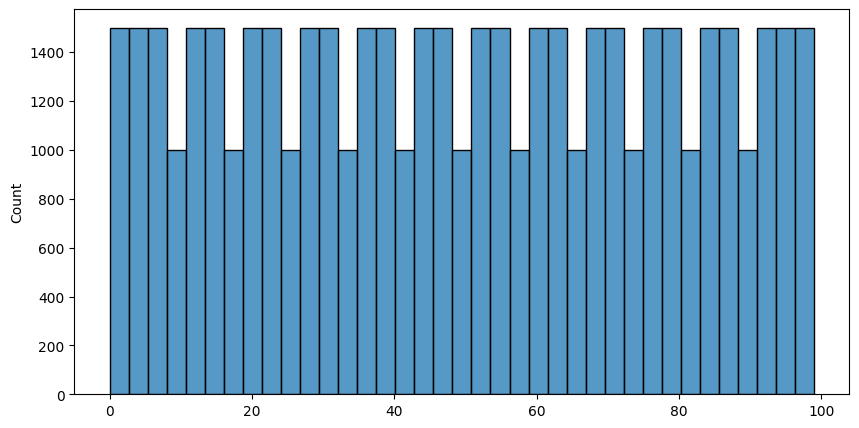

In [286]:
# show histogram of labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot([x['fine_label'] for x in dataset['train']])
plt.show()

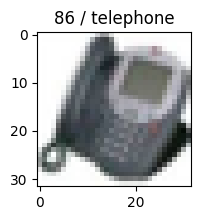

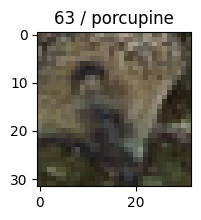

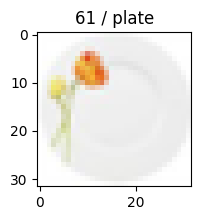

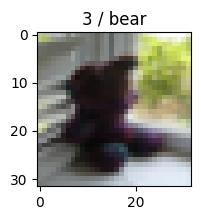

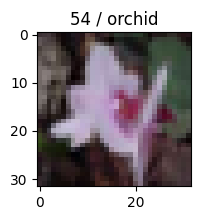

In [291]:
# sample images from dataset
import random

def sample_images(dataset, n=5):
    for i in range(n):
        x = random.choice(dataset['train'])
        plt.figure(figsize=(2, 2))
        plt.imshow(x['img'])
        plt.title(str(x['fine_label']) + ' / ' + cifar_labels[x['fine_label']])
        plt.show()

sample_images(dataset)

In [141]:
import numpy as np
import torch
import torchvision

def convert_dataset(dataset, labels_list):
    x = torch.stack([torch.Tensor(np.array(x['img'])) for x in dataset])
    # standardize images
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    y = torch.tensor([x['fine_label'] for x in dataset])
    return x, y

x, y = convert_dataset(dataset['train'], cifar_labels)
# print shapes
print(x.shape, y.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([50000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '39 / keyboard')

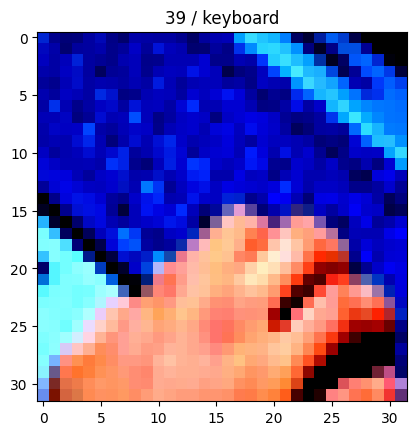

In [337]:
img_idx = 10
sample_img = x[img_idx].numpy()
# print labels from y tensor (y is one-hot encoded)
label_idx = y[img_idx].tolist()

plt.imshow(sample_img)
plt.title(str(label_idx) + ' / ' + cifar_labels[label_idx])

In [143]:
# train simple CNN model using PyTorch

import torch
import torch.nn as nn

class Net(nn.Module):

    def __init__(self, global_scale=1.0, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, int(6 * global_scale), 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(int(6 * global_scale), int(16 * global_scale), 5, padding=2)
        self.fc1 = nn.Linear(int(16 * 8 * 8 * global_scale), int(120 * global_scale))
        self.fc2 = nn.Linear(int(120 * global_scale), num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net(num_classes=len(cifar_labels))
print(net)

# print how many parameters are in the model overall
print(sum(p.numel() for p in net.parameters()))

example = torch.Tensor(x.permute(0, 3, 1, 2)[:1])
print(example.shape)
net(example)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
)
137972
torch.Size([1, 3, 32, 32])


tensor([[-0.0667,  0.2393,  0.0323,  0.0897, -0.0554, -0.0153, -0.0720, -0.1721,
          0.1123, -0.0497, -0.1607, -0.0177,  0.0891, -0.0945, -0.0415, -0.2031,
          0.0640,  0.1005,  0.0468,  0.0637, -0.1599, -0.1635,  0.0510,  0.0264,
          0.0536, -0.0146, -0.0175, -0.0390, -0.0266, -0.0755,  0.1621, -0.1017,
         -0.0357, -0.2197, -0.1394, -0.0862, -0.0384, -0.1211,  0.0886, -0.0552,
         -0.1310,  0.0340,  0.1464, -0.1299, -0.1712, -0.2489,  0.0984, -0.0720,
         -0.0141,  0.0895,  0.1923, -0.0145, -0.0890,  0.0376, -0.0572,  0.0767,
         -0.1684, -0.1290,  0.1180,  0.1183,  0.0940,  0.0423,  0.0822,  0.1221,
          0.0725, -0.0991,  0.0718, -0.0247,  0.1360, -0.0226,  0.0588,  0.0244,
          0.0612,  0.0615, -0.0580,  0.0706,  0.0605, -0.2082,  0.0238,  0.1631,
          0.0582,  0.0037, -0.0327, -0.0699, -0.1479,  0.0693,  0.0672,  0.0260,
          0.0215, -0.0212,  0.2300, -0.0473, -0.1348,  0.1079, -0.1146,  0.1198,
         -0.0223, -0.0407, -

In [144]:
# train the model

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 20
subset_size = 1000

x_subset = x[:subset_size].permute(0, 3, 1, 2)
y_subset = y[:subset_size]

for epoch in range(num_epochs):
    running_loss = 0.0
    # take input from x and y tensors
    for i, data in enumerate(zip(x_subset, y_subset)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.unsqueeze(0))
        loss = criterion(outputs, labels.unsqueeze(0))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # print every 2000 mini-batches
        # if i % 2000 == 1999:
        #     print(f"Epoch {epoch} loss: {running_loss / 200}")
        #     running_loss = 0.0

    print(f"Epoch {epoch} loss: {running_loss / len(x)}")
    

Epoch 0 loss: 0.09238324410438538
Epoch 1 loss: 0.09186878878593445
Epoch 2 loss: 0.0911579831457138
Epoch 3 loss: 0.08888038264036179
Epoch 4 loss: 0.08236994886327535
Epoch 5 loss: 0.07122399962589145
Epoch 6 loss: 0.05814928394056144
Epoch 7 loss: 0.0440202156470115
Epoch 8 loss: 0.03162076760299708
Epoch 9 loss: 0.022221988647022753
Epoch 10 loss: 0.01579706007343012
Epoch 11 loss: 0.0126834562904543
Epoch 12 loss: 0.01027612510225742
Epoch 13 loss: 0.008361674948036206
Epoch 14 loss: 0.007377226570392954
Epoch 15 loss: 0.007797221151621687
Epoch 16 loss: 0.0060949457158199155
Epoch 17 loss: 0.0058425939958498315
Epoch 18 loss: 0.0054484944161447
Epoch 19 loss: 0.004683076893747991


Epoch 0 loss: 0.09238324410438538
Epoch 1 loss: 0.09186878878593445
Epoch 2 loss: 0.0911579831457138
Epoch 3 loss: 0.08888038264036179
Epoch 4 loss: 0.08236994886327535
Epoch 5 loss: 0.07122399962589145
Epoch 6 loss: 0.05814928394056144
Epoch 7 loss: 0.0440202156470115
Epoch 8 loss: 0.03162076760299708
Epoch 9 loss: 0.022221988647022753
Epoch 10 loss: 0.01579706007343012
Epoch 11 loss: 0.0126834562904543
Epoch 12 loss: 0.01027612510225742
Epoch 13 loss: 0.008361674948036206
Epoch 14 loss: 0.007377226570392954
Epoch 15 loss: 0.007797221151621687
Epoch 16 loss: 0.0060949457158199155
Epoch 17 loss: 0.0058425939958498315
Epoch 18 loss: 0.0054484944161447
Epoch 19 loss: 0.004683076893747991

In [151]:
x_test, y_test = convert_dataset(dataset['test'], cifar_labels)
# print shapes
print(x_test.shape, y_test.shape)

torch.Size([10000, 32, 32, 3]) torch.Size([10000])


In [156]:
x_in = x_test.permute(0, 3, 1, 2)
y_test_pred = torch.argmax(net(x_in), dim=1)
y_test_pred.shape

torch.Size([10000])

In [157]:
# show values count for y_test_pred
import pandas as pd
pd.Series(y_test_pred.numpy()).value_counts()

4     418
75    270
98    265
62    245
53    217
     ... 
34     19
92     18
99     18
55      6
47      1
Name: count, Length: 100, dtype: int64

In [158]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.05      0.03      0.04       100
           1       0.10      0.03      0.05       100
           2       0.04      0.02      0.03       100
           3       0.01      0.01      0.01       100
           4       0.02      0.08      0.03       100
           5       0.03      0.06      0.04       100
           6       0.07      0.02      0.03       100
           7       0.04      0.03      0.03       100
           8       0.01      0.03      0.02       100
           9       0.03      0.01      0.01       100
          10       0.04      0.03      0.03       100
          11       0.04      0.06      0.05       100
          12       0.08      0.07      0.07       100
          13       0.01      0.02      0.02       100
          14       0.01      0.01      0.01       100
          15       0.03      0.02      0.02       100
          16       0.00      0.00      0.00       100
          17       0.02    

## Composability split try 1

### Class Embeddings

In [ ]:
!pip install wheel setuptools pip --upgrade
!pip install fasttext

In [254]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
words_emb = fasttext.load_model('cc.en.300.bin')

In [267]:
fasttext.util.reduce_model(words_emb, 10)
words_emb.get_dimension()

10

In [268]:
def get_ft_vector(ftmodel, text):
    if len(text.split('_')) == 0:
        return ftmodel.get_word_vector(text)
    else:
        # replace _ with space
        text = text.replace('_', ' ')
        return ftmodel.get_sentence_vector(text)
    
get_ft_vector(words_emb, 'hello_man')

array([ 0.02354577, -0.09955808, -0.3461216 , -0.31151217, -0.5118708 ,
       -0.10864205, -0.01830762, -0.10666388,  0.4581535 ,  0.12405477],
      dtype=float32)

In [269]:
def kMostSimilar(all_embeddings_corpus, embs_vectors, k=1):
    # find k nearest neighbors
    from sklearn.metrics.pairwise import cosine_similarity
    cos_sim = cosine_similarity(embs_vectors, all_embeddings_corpus)
    # sort by similarity
    top_k = np.argsort(-cos_sim, axis=1)[:, :k]
    return top_k

cifar_vectors = torch.Tensor([get_ft_vector(words_emb, l) for l in cifar_labels])

sample_words = ['man', 'apple', 'pinecone', 'nice man']
sample_inputs = torch.Tensor([get_ft_vector(words_emb, w) for w in sample_words])
print(cifar_vectors.shape, sample_inputs.shape)

kSimilars = kMostSimilar(cifar_vectors, sample_inputs, k=5)
print(kSimilars.shape)
for i, w in enumerate(sample_words):
    print(f'[{w}]', ' -> '.join([cifar_labels[knn] for knn in kSimilars[i]]))
    

torch.Size([100, 10]) torch.Size([4, 10])
(4, 5)
[man] man -> woman -> boy -> girl -> lion
[apple] apple -> bee -> squirrel -> turtle -> crab
[pinecone] crab -> sweet_pepper -> maple_tree -> pear -> lobster
[nice man] girl -> boy -> couch -> man -> lion


In [121]:
import numpy as np
import torch
import torchvision

def convert_dataset_embs(dataset, labels_list):
    x = torch.stack([torch.Tensor(np.array(x['img'])) for x in dataset])
    # standardize images
    mean = x.mean()
    std = x.std()
    x = (x - mean) / std
    y = torch.tensor([x['fine_label'] for x in dataset])
    y_embs = torch.stack([torch.Tensor(get_ft_vector(words_emb, labels_list[x['fine_label']])) for x in dataset])
    return x, y, y_embs

x, y, y_embs = convert_dataset_embs(dataset['train'], cifar_labels)
# print shapes
print(x.shape, y.shape, y_embs.shape)

torch.Size([50000, 32, 32, 3]) torch.Size([50000]) torch.Size([50000, 10])


In [112]:
# train simple CNN model using PyTorch

import torch
import torch.nn as nn

class SubNet(nn.Module):
    def __init__(self, global_scale=1.0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, int(6 * global_scale), 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(int(6 * global_scale), int(16 * global_scale), 5, padding=2)
        self.fc1 = nn.Linear(int(16 * 8 * 8 * global_scale), int(120 * global_scale))
        self.fc2 = nn.Linear(int(120 * global_scale), 1)  # Output layer with 1 neuron for regression
        self.activation = nn.Tanh()  # Linear activation function for regression

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.activation(self.fc2(x))  # Apply linear activation
        return x

net = SubNet(global_scale=.5)
print(net)

# print how many parameters are in the model overall
print(sum(p.numel() for p in net.parameters()))

SubNet(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (activation): Tanh()
)
31677


In [214]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [248]:
class CompleteNet(nn.Module):

    def __init__(self, sub_nets, all_embs_vectors):
        super().__init__()
        assert len(sub_nets) == all_embs_vectors.shape[1], 'Number of subnets must be equal to number of embeddings vectors'
        self.all_embs_vectors = all_embs_vectors
        self.sub_nets = nn.ModuleList(sub_nets)

    def forward(self, x):
        net_results = [net(x) for net in self.sub_nets]
        # build result vector from all subnets
        target_emb_vectors = torch.cat(net_results, dim=1)
        # calculate cosine similarity between embeddings and result vector and find k nearest neighbor
        # print('target_emb_vectors', target_emb_vectors.shape)
        most_similar_idx = kMostSimilar(self.all_embs_vectors, target_emb_vectors.detach().numpy(), k=1)[:, 0]
        # print('most_similar_idx', most_similar_idx.shape)
        # return one-hot encoded vector of length self.embs_vectors
        one_hot_vec = torch.nn.functional.one_hot(torch.tensor(most_similar_idx), num_classes=self.all_embs_vectors.shape[0]).float()
        # print('one_hot_vec', one_hot_vec.shape)
        assert one_hot_vec.shape == (x.shape[0], self.all_embs_vectors.shape[0]), 'One-hot vector shape must be equal to number of embeddings vectors'
        return one_hot_vec

# create subnets§
subnetworks = [SubNet(global_scale=.5) for _ in range(words_emb.get_dimension())]
# create complete network
complete_net = CompleteNet(subnetworks, cifar_vectors)

# print how many parameters are in the model overall
print(sum(p.numel() for p in complete_net.parameters()))

# run on example
example = torch.Tensor(x.permute(0, 3, 1, 2)[:2])
print(example.shape)
output = complete_net(example)
print(output.shape)
print(output[0])

316770
torch.Size([2, 3, 32, 32])
torch.Size([2, 100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [249]:
# do not show UserWarning
import warnings

warnings.filterwarnings("ignore")

# dim_idx = 0

# y = y_tf[:, dim_idx]

import torch.optim as optim

local_criterion = nn.MSELoss()  # Use Mean Squared Error loss for regression
local_optimizers = [optim.Adam(net.parameters(), lr=0.001) for net in complete_net.sub_nets]

global_criterion = nn.CrossEntropyLoss()

num_epochs = 20
subset_size = 1000

x_subset = x[:subset_size].permute(0, 3, 1, 2)
y_subset = y[:subset_size]
y_embs_subset = y_embs[:subset_size]

for epoch in range(num_epochs):
    running_global_loss = 0.0
    running_local_losses = [0.0 for _ in range(len(complete_net.sub_nets))]
    # take input from x and y tensors
    for epoch_i, data in enumerate(zip(x_subset, y_subset, y_embs_subset)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, target_embs_vecs = data

        for subnetwork_i, facilitators in enumerate(zip(local_optimizers, complete_net.sub_nets)):
            local_optimizer, subnet = facilitators

            local_target = target_embs_vecs[subnetwork_i]
            # zero the parameter gradients
            local_optimizer.zero_grad()

            # forward + backward + optimize
            local_outputs = subnet(inputs.unsqueeze(0))
            local_loss = local_criterion(local_outputs, local_target.unsqueeze(0))
            local_loss.backward()
            local_optimizer.step()

            # print statistics
            running_local_losses[subnetwork_i] += local_loss.item()

        # calculate global loss
        global_outputs = complete_net(inputs.unsqueeze(0))
        global_loss = global_criterion(global_outputs, labels.unsqueeze(0).long())

        # print statistics
        running_global_loss += global_loss.item()

    for i, local_loss in enumerate(running_local_losses):
        print(f"Local {i} Epoch {epoch} loss: {local_loss / len(x)}")

    print(f"Global Epoch {epoch} loss: {running_global_loss / len(x)}")


Local 0 Epoch 0 loss: 0.0005762299153593652
Local 1 Epoch 0 loss: 0.0005454265658189065
Local 2 Epoch 0 loss: 0.0008416036866124227
Local 3 Epoch 0 loss: 0.0008747367198716225
Local 4 Epoch 0 loss: 0.0007382234666135221
Local 5 Epoch 0 loss: 0.0009320512633844444
Local 6 Epoch 0 loss: 0.0012270698372349898
Local 7 Epoch 0 loss: 0.0014677060188762467
Local 8 Epoch 0 loss: 0.0010451747965098443
Local 9 Epoch 0 loss: 0.0010907633772548218
Global Epoch 0 loss: 0.09202413622379303
Local 0 Epoch 1 loss: 0.0005627123466482202
Local 1 Epoch 1 loss: 0.0004468055693395876
Local 2 Epoch 1 loss: 0.000719134777248372
Local 3 Epoch 1 loss: 0.0007850993477545737
Local 4 Epoch 1 loss: 0.0006632163452341953
Local 5 Epoch 1 loss: 0.0008501413054896
Local 6 Epoch 1 loss: 0.001151867989937591
Local 7 Epoch 1 loss: 0.0014226566043503476
Local 8 Epoch 1 loss: 0.0010264977090038774
Local 9 Epoch 1 loss: 0.001017129581989579
Global Epoch 1 loss: 0.09204413671016694
Local 0 Epoch 2 loss: 0.0005501017207311703


In [250]:
x_test, y_test, y_embs_test = convert_dataset_embs(dataset['test'], cifar_labels)
# print shapes
print(x_test.shape, y_test.shape, y_embs_test.shape)

torch.Size([10000, 32, 32, 3]) torch.Size([10000]) torch.Size([10000, 10])


In [251]:
x_in = x_test.permute(0, 3, 1, 2)
y_test_pred = torch.argmax(complete_net(x_in), dim=1)
y_test_pred.shape

torch.Size([10000])

In [252]:
# show values count for y_test_pred
import pandas as pd
pd.Series(y_test_pred.numpy()).value_counts()

15    773
77    520
30    520
4     478
56    443
     ... 
21      2
84      2
74      2
13      1
61      1
Name: count, Length: 94, dtype: int64

In [253]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.01      0.03      0.02       100
           1       0.03      0.01      0.02       100
           2       0.20      0.01      0.02       100
           3       0.00      0.00      0.00       100
           4       0.01      0.06      0.02       100
           5       0.02      0.01      0.01       100
           6       0.01      0.01      0.01       100
           7       0.00      0.00      0.00       100
           8       0.01      0.01      0.01       100
           9       0.05      0.01      0.02       100
          10       0.02      0.05      0.03       100
          11       0.00      0.00      0.00       100
          12       0.04      0.01      0.02       100
          13       0.00      0.00      0.00       100
          14       0.02      0.03      0.02       100
          15       0.02      0.14      0.03       100
          16       0.00      0.00      0.00       100
          17       0.00    

## 0's dimension
### Scale 1.0 Network
```
Epoch 0 loss: 0.005474975622930289
Epoch 1 loss: 0.005337374880918535
Epoch 2 loss: 0.005261764004205308
Epoch 3 loss: 0.005214934779614268
Epoch 4 loss: 0.005130238937003755
Epoch 5 loss: 0.005042624842824366
Epoch 6 loss: 0.0048896421648938915
Epoch 7 loss: 0.004735157112611078
Epoch 8 loss: 0.004570811293259825
Epoch 9 loss: 0.004456823233058836
```
### Scale 0.5 Network
31677 params - 3m 48.9s
```
Epoch 0 loss: 0.0055115460177579045
Epoch 1 loss: 0.005466778952138902
Epoch 2 loss: 0.005389073587050312
Epoch 3 loss: 0.005441364508157516
Epoch 4 loss: 0.005342579979085859
Epoch 5 loss: 0.005286336337010028
Epoch 6 loss: 0.005081268496543461
Epoch 7 loss: 0.005058598176602186
Epoch 8 loss: 0.004925254025041042
Epoch 9 loss: 0.004904557571217673
```

# Network Morph

## Load Existing Model

### ResNet50

In [2]:
# Download resnet50 with pretrained weights

from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
print(model)

# freeze all parameters
for param in model.parameters():
    param.requires_grad = False


/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### ResNet Tiny based on MNIST

In [2]:
# Use a pipeline as a high-level helper
# from transformers import pipeline
# pipe = pipeline("image-classification", model="fxmarty/resnet-tiny-mnist")

# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

# processor = AutoImageProcessor.from_pretrained("fxmarty/resnet-tiny-mnist")
model = AutoModelForImageClassification.from_pretrained("fxmarty/resnet-tiny-mnist")

# freeze all parameters
for param in model.parameters():
    param.requires_grad = False

model

/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 32, k

## Dataset

### CIFAR10

In [53]:
# download imagenet
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),             # Resize to 256x256
    transforms.CenterCrop(224),         # Crop to 224x224 (expected by ResNet)
    transforms.ToTensor(),              # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


### ImageNet

In [8]:
# download imagenet
from datasets import load_dataset
import torchvision.transforms as transforms

#trainset = torchvision.datasets.ImageNet(root='./data', split='train', download=True, transform=transform)
ds = load_dataset("imagenet-1k", split="train", streaming=True)
print('ds loaded')
# ds = load_dataset("zh-plus/tiny-imagenet")
# transform = transforms.Compose([
#     # The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR
#     transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.CenterCrop(224),         # Crop to 224x224 (expected by ResNet)
#     transforms.ToTensor(),              # Convert to Tensor to [0.0, 1.0]
#     #then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
# ])
transfrom = ResNet50_Weights.IMAGENET1K_V2.transforms
# transform on trainset
ds = ds \
    .filter(lambda x: x['image'].mode == 'RGB') \
    .map(lambda x: {'image': ResNet50_Weights.IMAGENET1K_V2.transforms(x['image']), 'label': x['label']})

/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for imagenet-1k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/imagenet-1k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


ds loaded


In [9]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=1)
dataiter = iter(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(726)


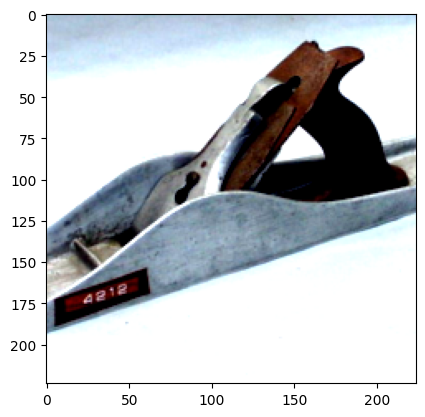

In [150]:
# Step 3: Get a Batch of Data (in this case, just one image for demonstration)
batch = next(dataiter)
images, labels = batch['image'], batch['label']

# print image using pytroch
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
print(labels[0])
imshow(images[0])

In [151]:
# Step 4: Run an Image Through the Model
outputs = model(images)
print(outputs.shape)

_, predicted = torch.max(outputs.data, 1)
print(f"Predicted class index: {predicted.item()} with label: {labels[0].item()}")

AttributeError: 'tuple' object has no attribute 'shape'

#### Eval on pretrained

In [192]:
# evaluate model on imagenet

correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(dataloader):
        images, labels = data['image'], data['label']
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 0:
            print(f'Accuracy of the network on {i} images: {100 * correct / total}%')

AttributeError: 'ImageClassifierOutputWithNoAttention' object has no attribute 'data'

### MNIST

In [3]:
# Download ImageNet from Hugging Face hub

from datasets import load_dataset

# dataset = load_dataset("cifar100")
ds = load_dataset("mnist", streaming=True)

import transformers
import torchvision.transforms as transforms
feature_extractor = transformers.ConvNextFeatureExtractor(
    do_resize=False, do_normalize=False, image_mean=[0.45], image_std=[0.22]
)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)]
)

ds = ds.map(lambda x: {'image': transform(x['image']), 'label': x['label']})

/Users/shacharproj/Projects/personal/nn-optimizations/.venv/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [171]:
# first image from mnist_ds
sample = next(dataiter)
image, label = sample['image'][0], sample['label'][0]

inputs = transform(image).unsqueeze(0)
print(inputs.shape)
# show image of size [1, 28, 28]
outputs = model(inputs)

predicted_class = outputs.logits.argmax(-1).item()

print(f"Predicted class: '{predicted_class}' with label: '{label}'")
image

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>

#### Eval on pretrained

In [190]:
dataloader = torch.utils.data.DataLoader(ds['test'], batch_size=1)

In [191]:
# evaluate model on imagenet

correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(dataloader):
        inputs, labels = data['image'], data['label']
        outputs = model(inputs)
        predicted_class = outputs.logits.argmax(-1).item()
        total += labels.size(0)
        correct += (predicted_class == labels).sum().item()
        if i % 1000 == 0:
            print(f'Accuracy of the network on {i} images: {100 * correct / total}%')

Accuracy of the network on 0 images: 0.0%
Accuracy of the network on 1000 images: 18.781218781218783%
Accuracy of the network on 2000 images: 19.440279860069964%


KeyboardInterrupt: 

## Morph

### Replace FC with new layer + FC

In [283]:
import torch.nn as nn

# add a layer to the model before the output layer
latent_dim = 10

num_ftrs = model.fc.in_features
num_out = model.fc.out_features

# Now, create a sequential model to include the new layer followed by the original fc layer
# Note: You might need to adjust the output features of the new layer and the input features of the final layer based on your requirements
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, latent_dim),
    nn.ReLU(),  # Optional: Add activation function if needed
    nn.Linear(latent_dim, num_out)
)

# Verify the modified model structure
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Replace FC with VAE

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class VAEMorph(nn.Module):

    def __init__(self, morphed_fc_layer, latent_dim=256):
        super(VAEMorph, self).__init__()

        num_ftrs = morphed_fc_layer.in_features
        num_out = morphed_fc_layer.out_features

        self.encoder = nn.Sequential(
            nn.Linear(num_ftrs, latent_dim),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, num_out),
            # nn.LeakyReLU(0.2), # TODO: should be similar to original layer
        )
        

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# print(model.fc)
# print(VAEMorph(model.fc))

print(model.classifier[-1])
print(VAEMorph(model.classifier[-1]))

Linear(in_features=64, out_features=10, bias=True)
VAEMorph(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [20]:
class ResnetWithVAE(nn.Module):

    def __init__(self, resnet, latent_dim=256):
        super(ResnetWithVAE, self).__init__()
        self.resnet = resnet
        self.vae_to_fc = VAEMorph(resnet.fc, latent_dim)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)

        x, mean, logvar = self.vae_to_fc(x)

        return x, mean, logvar
    
vae_model = ResnetWithVAE(model, latent_dim=256)
print(vae_model)

AttributeError: 'ResNetForImageClassification' object has no attribute 'fc'

In [5]:
from typing import Optional

class TinyResnetWithVAE(transformers.ResNetPreTrainedModel):

    def __init__(self, prev_model, latent_dim):
        super().__init__(prev_model.config)
        # classification head
        self.resnet = prev_model.resnet
        self.classifier = nn.Sequential(
            nn.Flatten(),
            VAEMorph(model.classifier[-1], latent_dim)
        )

    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.resnet(pixel_values, output_hidden_states=output_hidden_states, return_dict=return_dict)

        pooled_output = outputs.pooler_output if return_dict else outputs[1]

        x, mean, logvar = self.classifier(pooled_output)

        return x, mean, logvar
    
vae_model = TinyResnetWithVAE(model, latent_dim=4)
print(vae_model)

TinyResnetWithVAE(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 32, kernel_size=

In [10]:
# VAE loss function
def vae_loss(x, x_hat, mean, log_var):
    reproduction_loss = nn.CrossEntropyLoss()(x_hat, x)
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

## Fine Tune

In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(ds['test'], batch_size=batch_size)

In [9]:
dataiter = iter(train_loader)
batch = next(dataiter)
images, labels = batch['image'], batch['label']

x = images.to(device)
output, mean, log_var = vae_model(x)

_, y_hat = torch.max(output.data, 1)
loss = vae_loss(labels, output, mean, log_var)
labels.shape, y_hat.shape, output.shape, mean.shape, log_var.shape, labels, y_hat, loss

(torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 10]),
 torch.Size([32, 2]),
 torch.Size([32, 2]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8]),
 tensor([0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 7, 6, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 6, 0, 0]),
 tensor(13.6456, grad_fn=<AddBackward0>))

In [13]:
import copy

# Assuming 'model' is your PyTorch model
initial_weights = copy.deepcopy(vae_model.state_dict())

In [15]:
# train the model

import torch.optim as optim
def eval(test_loader, model, loss_function, epoch):
    # calculate test loss
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data['image'], data['label']
            output, mean, log_var = model(inputs)
            loss = loss_function(labels, output, mean, log_var)
            test_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("\tEpoch", epoch, "\tAverage Test Loss: ", test_loss, "\tAccuracy: ", 100 * correct / total)

def train(train_loader, model, loss_function, epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for i, data in enumerate(train_loader):
            batch_idx = i + 1
            images, labels = data['image'], data['label']
            x = images.to(device)

            optimizer.zero_grad()

            output, mean, log_var = model(x)
            loss = loss_function(labels, output, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            if batch_idx % 500 == 0:
                print("\tEpoch", epoch + 1, "\tBatch", batch_idx, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
                eval(test_loader, model, loss_function, epoch + 1)

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return optimizer, overall_loss

def ce_loss(x, x_hat, mean, log_var):
    return nn.CrossEntropyLoss()(x_hat, x)

loss_function = vae_loss
eval(test_loader, vae_model, loss_function, 0)
optimizer, overall_loss = train(train_loader, vae_model, loss_function, epochs=6, device=device)

	Epoch 0 	Average Test Loss:  192.658611536026 	Accuracy:  90.14
	Epoch 1 	Batch 500 	Average Loss:  0.01918425825983286
	Epoch 1 	Average Test Loss:  189.31522020697594 	Accuracy:  90.33
	Epoch 1 	Batch 1000 	Average Loss:  0.019098714308813214
	Epoch 1 	Average Test Loss:  200.91548064351082 	Accuracy:  86.49
	Epoch 1 	Batch 1500 	Average Loss:  0.01895444613819321
	Epoch 1 	Average Test Loss:  186.44691234827042 	Accuracy:  90.25
	Epoch 1 	Average Loss:  0.018652253980437915
	Epoch 2 	Batch 500 	Average Loss:  0.01767102162912488
	Epoch 2 	Average Test Loss:  172.81538781523705 	Accuracy:  91.2
	Epoch 2 	Batch 1000 	Average Loss:  0.017619418571703137
	Epoch 2 	Average Test Loss:  185.52459028363228 	Accuracy:  88.99
	Epoch 2 	Batch 1500 	Average Loss:  0.017485486212496956
	Epoch 2 	Average Test Loss:  168.45114913582802 	Accuracy:  91.46
	Epoch 2 	Average Loss:  0.017145232510070007
	Epoch 3 	Batch 500 	Average Loss:  0.01589475332573056
	Epoch 3 	Average Test Loss:  153.086262851

In [49]:
# After an update (e.g., after an epoch)
new_weights = vae_model.state_dict()

for name in new_weights:
    weight_change = (new_weights[name] - initial_weights[name]).abs().sum()
    print(f'Change in weights for {name}: {weight_change}')
    initial_weights[name] = new_weights[name].clone()

Change in weights for resnet.embedder.embedder.convolution.weight: 0.0
Change in weights for resnet.embedder.embedder.normalization.weight: 0.0
Change in weights for resnet.embedder.embedder.normalization.bias: 0.0
Change in weights for resnet.embedder.embedder.normalization.running_mean: 0.01381131075322628
Change in weights for resnet.embedder.embedder.normalization.running_var: 0.11022835969924927
Change in weights for resnet.embedder.embedder.normalization.num_batches_tracked: 2350
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: 0.0
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: 0.0
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: 0.0
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.running_mean: 0.8663872480392456
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.running_var: 2.2254467010498047
Change in weights for 

### Eval

In [50]:
dataloader = torch.utils.data.DataLoader(ds['test'], batch_size=1)

In [18]:
# evaluate model on imagenet

correct = 0
total = 0
test_cp_loss = 0
test_kl_loss = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data['image'], data['label']
        output, mean, log_var = vae_model(inputs)
        loss = loss_function(labels, output, mean, log_var)
        # reproduction_loss = nn.CrossEntropyLoss()(labels, output)
        KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        # test_cp_loss += reproduction_loss.item()
        test_kl_loss += KLD.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("\tAverage CP Test Loss: ", test_cp_loss, "\tAverage KL Test Loss: ", test_kl_loss, "\tAccuracy: ", 100 * correct / total)

	Average CP Test Loss:  0 	Average KL Test Loss:  156.40316820144653 	Accuracy:  93.435


In [21]:
images

AttributeError: 'str' object has no attribute 'shape'

In [25]:
predicted.indices

tensor([7, 2, 1, 0, 4, 1, 4, 8, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1
    7     2     1     0     4     1     4     8     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1


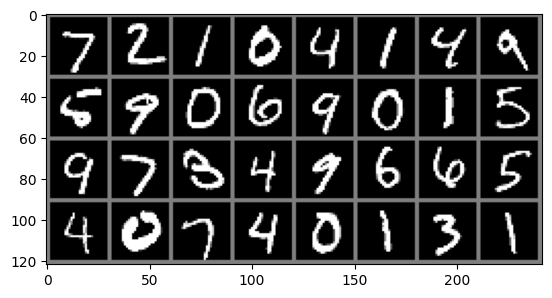

In [39]:
# see examples of images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(test_loader)
data = next(dataiter)
images, labels = data['image'], data['label']

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % label.item() for label in labels))
# print predictions
outputs, _, _ = vae_model(images)
_, predicted = torch.max(outputs.data, 1)
print(' '.join('%5s' % p for p in predicted.numpy()))

## Analyze VAE

In [102]:
## Get VAE layer

# This list will hold the outputs of layer L
outputs_of_L = []
target_layer = vae_model.classifier[-1].decoder[1]

# Define the hook function
def hook_function(module, input, output):
    # Append the output of layer L to the list
    outputs_of_L.append(output)

# Attach the hook function to the layer L
hook = vae_model.classifier[-1].decoder[1].register_forward_hook(hook_function)

In [106]:
# go over the data

# evaluate model on imagenet

outputs_of_L = []
all_inputs = []

with torch.no_grad():
    for data in torch.utils.data.DataLoader(ds['train'], batch_size=1):
        inputs, labels = data['image'], data['label']
        _, _, _ = vae_model(inputs)
        all_inputs.append([inputs[0], labels[0]])

assert len(outputs_of_L) == len(all_inputs)

In [126]:
import pandas as pd
all_data_df = pd.DataFrame([[i[0], i[1], l[0]] for i, l in zip(all_inputs, outputs_of_L)])
all_data_df.rename(columns={0: 'images', 1: 'labels', 2: 'layer'}, inplace=True)
# unpack col2 array to columns
all_data_df = pd.concat([all_data_df.drop('layer', axis=1), all_data_df.layer.apply(pd.Series)], axis=1)
all_data_df['labels'] = all_data_df['labels'].apply(lambda x: x.item())
all_data_df

,images,labels,0,1,2,3
0,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",5,1.733988,0.830283,1.440250,1.226602
1,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",0,1.667151,0.883581,1.620113,1.070037
2,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",4,1.553556,1.024692,1.459559,1.239546
3,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",1,1.559128,1.017436,1.470518,1.228351
4,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",9,1.637346,0.920743,1.576723,1.115694
...,...,...,...,...,...,...
59995,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",8,1.625999,0.948870,1.431204,1.253598
59996,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",3,1.604439,0.963235,1.515321,1.178711
59997,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",5,1.754972,0.806314,1.450547,1.213378
59998,"[[[tensor(-2.0455), tensor(-2.0455), tensor(-2...",6,1.776706,0.780476,1.470563,1.190945


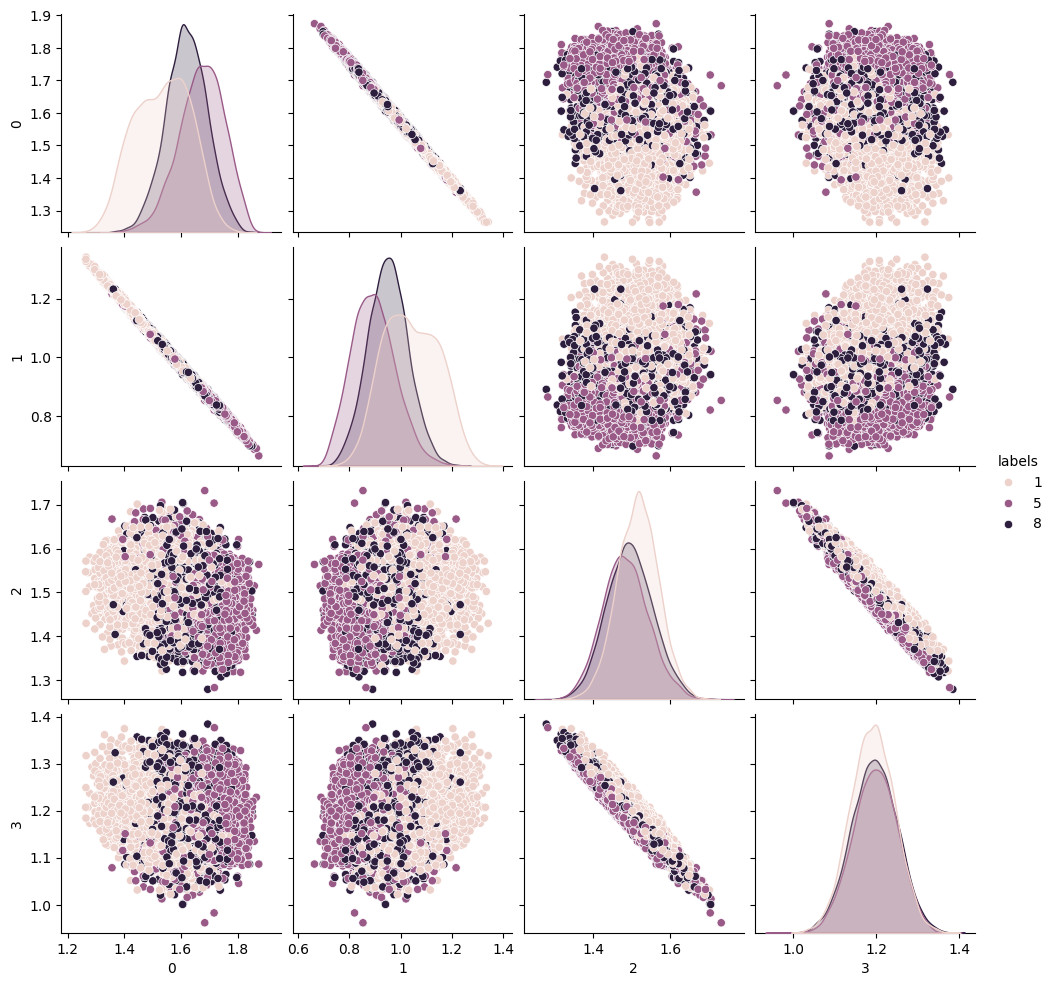

In [154]:
# draw a scatter plots of columns [0, 1, 2, 3] and color is labels
import seaborn as sns
import matplotlib.pyplot as plt

# plot
sns.pairplot(all_data_df.loc[all_data_df.labels.isin((1, 5, 8)), ['labels', 0, 1, 2, 3]], hue='labels', diag_kind='kde')
plt.show()

In [155]:
# calculate spearman correlation
all_data_df.loc[:, [0, 1, 2, 3, 'labels']].corr(method='pearson')

,0,1,2,3,labels
0,1.000000,-0.997727,-0.181481,-0.089298,-0.000527
1,-0.997727,1.000000,0.114809,0.156205,0.007757
2,-0.181481,0.114809,1.000000,-0.963260,-0.105443
3,-0.089298,0.156205,-0.963260,1.000000,0.106939
labels,-0.000527,0.007757,-0.105443,0.106939,1.000000


# Retrain one layer

In [182]:
last_layer = model.classifier[-1]
# set weights to xaiver normal
nn.init.xavier_normal_(last_layer.weight)

Parameter containing:
tensor([[ 1.1854e-02,  1.8003e-01, -1.1766e-01,  1.5348e-01,  1.2391e-01,
          1.3242e-01,  1.0409e-01,  2.4221e-01,  3.0654e-01,  1.4045e-03,
          7.7618e-02, -1.1253e-02, -2.6668e-02, -7.9384e-02,  2.0346e-01,
         -1.8850e-01, -1.1410e-01,  2.5067e-01,  1.2005e-01, -1.6243e-01,
          5.8971e-02,  6.4384e-02,  8.6867e-02,  1.4570e-01, -8.2333e-02,
          1.4361e-02,  1.1194e-01, -9.7863e-02,  3.8683e-01,  5.0022e-02,
         -1.3935e-01, -2.3870e-01, -3.0442e-01, -3.1574e-01, -9.7927e-02,
         -1.1970e-01, -2.9855e-02,  1.8010e-01, -6.5184e-02,  3.9407e-02,
         -1.3865e-01,  5.4266e-02,  3.7850e-02,  9.0167e-02,  1.1907e-01,
         -6.2676e-03,  1.1256e-01, -7.6263e-02, -6.8196e-02,  2.5946e-01,
          7.0781e-02,  4.0026e-01, -3.0120e-01, -1.2702e-01, -4.4714e-03,
          1.8383e-01, -1.2428e-02,  2.4577e-01, -2.2592e-01, -8.6666e-02,
          2.0558e-01, -1.5514e-01,  5.9377e-02,  1.2210e-02],
        [-4.2720e-02, -2.540

In [183]:
# unfreeze last layer
for param in last_layer.parameters():
    param.requires_grad = True

In [184]:
import copy

# Assuming 'model' is your PyTorch model
initial_weights = copy.deepcopy(model.state_dict())

In [175]:
for param in model.parameters():
    param.requires_grad = True

In [185]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(ds['test'], batch_size=batch_size)

In [189]:
# train model

import torch.optim as optim

def eval(model, criteria, epoch, test_loader):
    # calculate test loss
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data['image'], data['label']
            outputs = model(inputs)
            loss = criteria(outputs.logits, labels)
            test_loss += loss.item()
            predicted = outputs.logits.argmax(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("\tEpoch", epoch, "\tAverage Test Loss: ", test_loss, "\tAccuracy: ", 100 * correct / total)

def train(model, loss_function, epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for i, data in enumerate(train_loader):
            batch_idx = i + 1
            images, labels = data['image'], data['label']
            x = images.to(device)

            optimizer.zero_grad()

            output = model(x)
            loss = loss_function(output.logits, labels)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            if batch_idx % 500 == 0:
                print("\tEpoch", epoch + 1, "\tBatch", batch_idx, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
                eval(model, criteria, epoch + 1, test_loader)

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return optimizer, overall_loss

criteria = nn.CrossEntropyLoss()

eval(model, criteria, 0, test_loader)
optimizer, overall_loss = train(model, criteria, epochs=6, device=device)

KeyboardInterrupt: 

In [140]:
data = next(iter(train_loader))
images, labels = data['image'], data['label']
x = images.to(device)

output = model(x)
print(x.shape, labels.shape, output.logits.shape)
#nn.CrossEntropyLoss()(output.logits[1], labels[1]), nn.CrossEntropyLoss()(output.logits[0], labels[1]), nn.CrossEntropyLoss()(output.logits[0], labels[0]), nn.CrossEntropyLoss()(output.logits[1], labels[0])
nn.CrossEntropyLoss()(output.logits, labels).item()

torch.Size([32, 1, 28, 28]) torch.Size([32]) torch.Size([32, 10])


0.042086128145456314

In [103]:
# After an update (e.g., after an epoch)
new_weights = model.state_dict()

for name in new_weights:
    weight_change = (new_weights[name] - initial_weights[name]).abs().sum()
    print(f'Change in weights for {name}: {weight_change}')
    initial_weights[name] = new_weights[name].clone()

Change in weights for resnet.embedder.embedder.convolution.weight: 127.01602935791016
Change in weights for resnet.embedder.embedder.normalization.weight: 3.8685879707336426
Change in weights for resnet.embedder.embedder.normalization.bias: 4.462992191314697
Change in weights for resnet.embedder.embedder.normalization.running_mean: 30.147193908691406
Change in weights for resnet.embedder.embedder.normalization.running_var: 64.54914855957031
Change in weights for resnet.embedder.embedder.normalization.num_batches_tracked: 5659
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.convolution.weight: 99.6905288696289
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.weight: 0.8105117082595825
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.bias: 1.4153374433517456
Change in weights for resnet.encoder.stages.0.layers.0.shortcut.normalization.running_mean: 27.78400421142578
Change in weights for resnet.encoder.stages.0.lay